To install helix, run `pip install -e /path/to/helix/repo` 

In [1]:
import numpy as np
import strax as sx
import numba
import pandas as pd
import scipy as sp
import sys
import os

# Extract the active environment name from the CONDA_PREFIX environment variable
conda_env = os.environ.get('CONDA_DEFAULT_ENV', None)
print(f"Active Conda Environment: {conda_env}")


print("strax version:", sx.__version__)
print("NumPy version:", np.__version__)
print("Numba version:", numba.__version__)
print("Pandas version:", pd.__version__)
print("SciPy version:", sp.__version__)
!python --version


Active Conda Environment: hupdate
strax version: 2.0.4
NumPy version: 1.26.4
Numba version: 0.60.0
Pandas version: 2.2.3
SciPy version: 1.15.1
Python 3.12.8


In [2]:
import helix as hx
print("helix version:", hx.__version__)


helix version: 0.0.0


In [3]:
import shutil
from glob import glob
from matplotlib import pyplot as plt


## Generate toy data

Toy data generator is very slow, might take ~20 seconds per 10 seconds of toy data. Don't ask for a lot of toy data if you don't want to wait forever

In [4]:
run_id = 'run10' 
duration = 30  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel

In [5]:
# remove helix data corresponding to this run_id, if it exists
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
hx.generate_toy_data(run_id, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)

100%|████| 2/2 [01:25<00:00, 42.60s/it]


## Process the toy data

In [7]:
# creating context, registering storage and plugins
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

# passing the settings to the plugins. Strax finds which plugins take these options automatically
context.set_config(config)

# running the processing (or retrieving the data, if it was processed earlier)
#psds = context.get_array(run_id, 'noise_psds')  # Helix needs to prebuild PSDs before calculating fit_results 
fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type

# fit_results is a structured numpy array of events containing fields described in the FitResults documentation
# one can work with it as a dictionary on numpy arrays, or as a numpy array of dictionaries. Works both ways. E.g.
# fit_results['sum_uv_amplitude'][:100]  # amplitudes of UV signals in the sum of all channels in the first 100 events
# fit_results[:100]['sum_uv_amplitude']  # same

Removing old incomplete data in test_helix_data/run10-raw_records-igg4zuk5jh_temp
Removing old incomplete data in test_helix_data/run10-qp_triggers-i3vt2yhwmr_temp
Removing old incomplete data in test_helix_data/run10-uv_triggers-xdpckrv34a_temp
Removing old incomplete data in test_helix_data/run10-noise_events-buppqjifr3_temp
Removing old incomplete data in test_helix_data/run10-noise_psds-byulhk6gvu_temp
Removing old incomplete data in test_helix_data/run10-events-maxkkktkcx_temp
Removing old incomplete data in test_helix_data/run10-fit_results-volvnpzpr6_temp


Loading fit_results: | | 0.00 % [00:00<

Source finished!


Loading fit_results: | | 0.00 % [01:19<


In [8]:
# to show all the field names stored in the fit_results numpy structured array
fit_results.dtype.names

('time',
 'length',
 'dt',
 'block_id',
 'event_id',
 'channels',
 'submerged_channel_uv_amplitude',
 'submerged_channel_fit_chi2',
 'submerged_channel_uv_offset',
 'submerged_sum_uv_amplitude',
 'submerged_sum_fit_chi2',
 'submerged_sum_uv_offset',
 'submerged_triggered_uv_amplitude',
 'submerged_triggered_fit_chi2',
 'submerged_triggered_uv_offset',
 'submerged_triggered_channel_masks',
 'vacuum_channel_uv_amplitude',
 'vacuum_channel_qp_amplitude',
 'vacuum_channel_fit_chi2',
 'vacuum_channel_uv_offset',
 'vacuum_channel_qp_offset',
 'vacuum_sum_uv_amplitude',
 'vacuum_sum_qp_amplitude',
 'vacuum_sum_fit_chi2',
 'vacuum_sum_uv_offset',
 'vacuum_sum_qp_offset',
 'vacuum_triggered_uv_amplitude',
 'vacuum_triggered_qp_amplitude',
 'vacuum_triggered_fit_chi2',
 'vacuum_triggered_uv_offset',
 'vacuum_triggered_qp_offset',
 'vacuum_triggered_channel_masks',
 'triggered_uv_amplitude',
 'triggered_qp_amplitude',
 'triggered_fit_chi2',
 'triggered_uv_offset',
 'triggered_qp_offset',
 'trigge

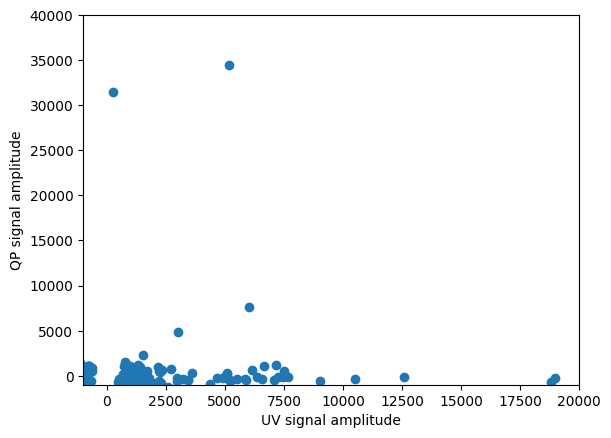

In [9]:
# 2d scatter plot of QP vs UV signal amplitudes
plt.scatter(fit_results['triggered_uv_amplitude'], fit_results['triggered_qp_amplitude'])
plt.xlabel('UV signal amplitude')
plt.ylabel('QP signal amplitude')
plt.xlim(-1000, 20000)
plt.ylim(-1000, 40000)
plt.show()

In [10]:
events = context.get_array(run_id, 'events')

Loading events: | | 0.00 % [00:00<?], #


In [11]:
events.dtype.names

('time',
 'length',
 'dt',
 'block_id',
 'block_time',
 'event_id',
 'start_loc',
 'channel_data',
 'channels',
 'data',
 'summed_channel_types',
 'summed_channel_masks')

In [12]:
# Building the channel map and loading the templates

channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

template_path = './plugins/event_rqs/default_templates.npy'
templates = np.load(template_path, allow_pickle=True)
uv_template = templates[0]
qp_template = templates[1]

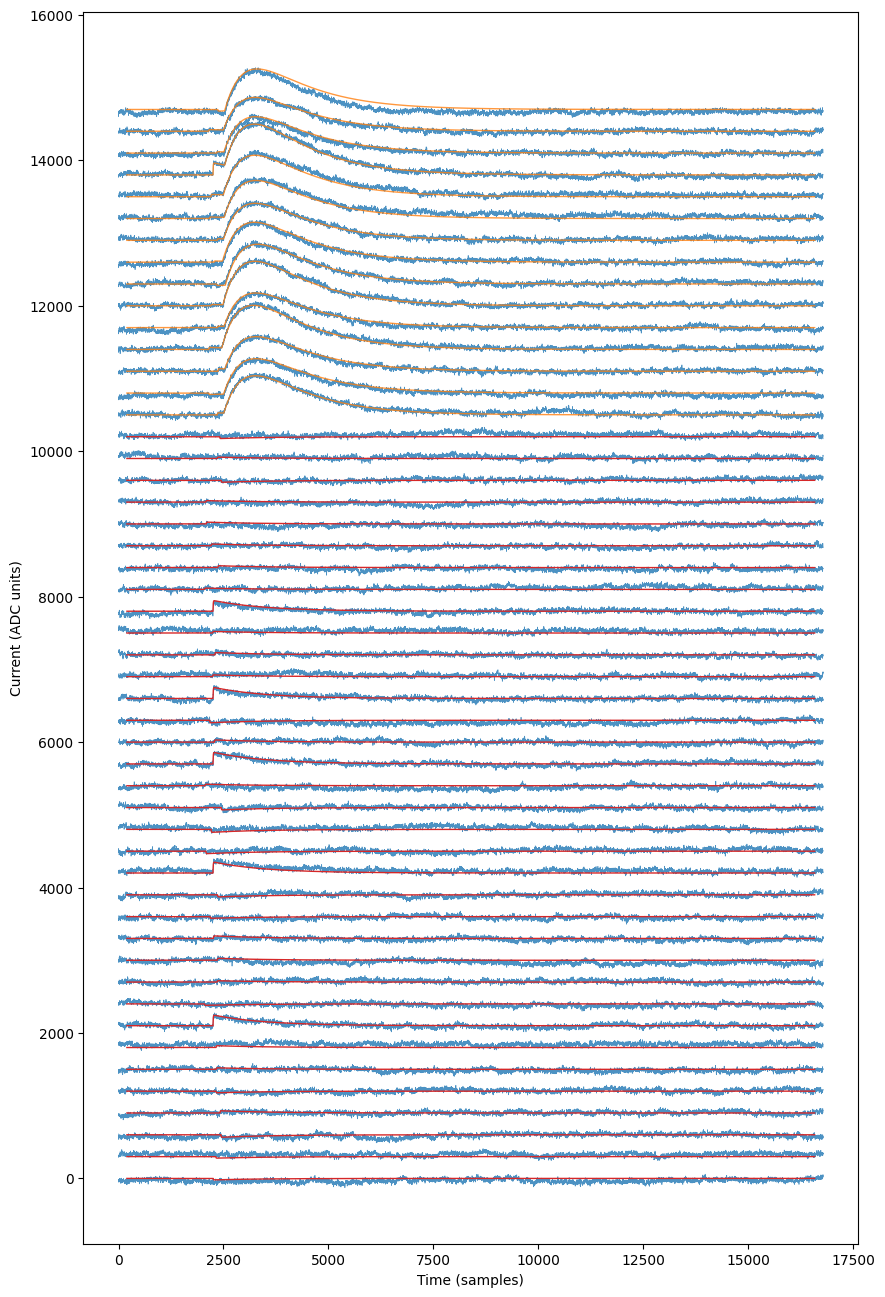

In [13]:
# change this to choose another event if the one below is a bad one by chance
i = 3

plt.figure(figsize=(10,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][i].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel

event = fit_results[i]

# plotting two-template fits in the vacuum channels
for i_vac, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.VACUUM)):
    # i_vac is the ordinal index of the vacuum channel
    # i_ch is the corrending ordinal index in the array of all channels
    fit = event['vacuum_channel_uv_amplitude'][i_vac] * np.roll(uv_template, event['vacuum_channel_uv_offset'][i_vac]) + \
          event['vacuum_channel_qp_amplitude'][i_vac] * np.roll(qp_template, event['vacuum_channel_qp_offset'][i_vac])
    x = np.arange(len(uv_template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]  # currently, the FitResults plugin does not fit the entire event. It skips -hx.DEFAULT_ALLOWED_FIT_SHIFTS[0] samples.
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, alpha=0.8, color='C1')

# plotting one-template fits in the submerged channels
for i_sub, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.SUBMERGED)):
    fit = event['submerged_channel_uv_amplitude'][i_sub] * np.roll(uv_template, event['submerged_channel_uv_offset'][i_sub])
    x = np.arange(len(uv_template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, color='C3')


plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.show()

### Please, clear the output of all cells after running this notebook. Do not push the cell outputs to git!
In the upper left corner click Edit -> Clear outputs of all cells

In [ ]:
import helix as hx
import strax as sx

run = 'run10'
output_dir = 'test_helix_data'

# creating context, registering storage and plugins
context = sx.Context(storage=[sx.DataDirectory(output_dir, provide_run_metadata=True), ],
                     register=[hx.ToyDataRawRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': output_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}             # for the hx.NoiseEvents plugin

# passing the settings to the plugins. Strax finds which plugins take these options automatically
context.set_config(config)

# running the processing (or retrieving the data, if it was processed earlier)
fit_results = context.get_array(run, 'fit_results')  # hx.FitResults plugin provides this data type 

# fit_results is a structured numpy array of events containing fields described in the FitResults documentation
# one can work with it as a dictionary on numpy arrays, or as a numpy array of dictionaries. Works both ways. E.g.
# fit_results['sum_uv_amplitude'][:100]  # amplitudes of UV signals in the sum of all channels in the first 100 events
# fit_results[:100]['sum_uv_amplitude']  # same
